#  DIO: Facial Recognition Project

**Install Libraries**

In [ ]:
!pip install tensorflow mtcnn keras-facenet scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.2 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=041fd11fef8acb5d80e5508788cac6e0b370e763a359cac22b9c02f1acafb51d
  Stored in directory: /root/.cache/pip/wheels/05/b0/f5/19ac49fedc10b1df3ee56b096edbcfa39d45794fccc6bcdbbf
Successfully built keras-facenet


**Import Libraries and Mount Google Drive**

In [ ]:
import os
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import pickle
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive to the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


**Function to load the dataset and extract embeddings**

In [ ]:
def load_dataset_and_extract_embeddings(dataset_path):
    """
    Processes an image directory, detects faces, extracts embeddings,
    and returns the embeddings (X) and the labels (y).
    """
    detector = MTCNN()
    embedder = FaceNet()

    list_embeddings = []
    list_labels = []

    for person_name in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_name)
        if not os.path.isdir(person_path):
            continue

        print(f"[INFO] Processing person: {person_name}")

        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)

            try:
                image = cv2.imread(image_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = detector.detect_faces(image_rgb)

                if results:
                    x1, y1, width, height = results[0]['box']
                    x1, y1 = abs(x1), abs(y1)
                    x2, y2 = x1 + width, y1 + height

                    face = image_rgb[y1:y2, x1:x2]
                    face_resized = cv2.resize(face, (160, 160))
                    face_embedding = embedder.embeddings([face_resized])[0]

                    list_embeddings.append(face_embedding)
                    list_labels.append(person_name)
            except Exception as e:
                print(f"  [WARNING] Error processing image {image_path}: {e}")

    return np.asarray(list_embeddings), np.asarray(list_labels)


**Executing the extraction**

In [ ]:
base_path = '/content/drive/MyDrive/Facial_Recognition_Project/'
dataset_path = os.path.join(base_path, 'dataset')
models_path = os.path.join(base_path, 'models')

# Create the models folder if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Generate embeddings and labels
X, y = load_dataset_and_extract_embeddings(dataset_path)

print(f"\n[INFO] Extraction complete. Total embeddings: {len(X)}")

[INFO] Processing person: Mario
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[INFO] Processing person: Joana
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

**Training the SVM classifier and LabelEncoder**

In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create and train the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X, y_encoded)

# Save the trained model and the encoder to Google Drive
with open(os.path.join(models_path, 'svm_model.pkl'), 'wb') as f:
    pickle.dump(svm_model, f)
with open(os.path.join(models_path, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(encoder, f)

print("[INFO] SVM training complete and models saved.")

[INFO] SVM training complete and models saved.


**Function to recognize faces in a PHOTO FILE**

In [ ]:
def recognize_faces_in_photo(test_image_path):
    try:
        with open(os.path.join(models_path, 'svm_model.pkl'), 'rb') as f:
            svm_model = pickle.load(f)
        with open(os.path.join(models_path, 'label_encoder.pkl'), 'rb') as f:
            encoder = pickle.load(f)
    except FileNotFoundError:
        print("[ERROR] SVM or Encoder models not found. Execute the previous cells.")
        return

    detector = MTCNN()
    embedder = FaceNet()

    try:
        frame = cv2.imread(test_image_path)
        if frame is None:
            print(f"[ERROR] Could not load image: {test_image_path}")
            return
    except Exception as e:
        print(f"[ERROR] Error loading image: {e}")
        return

    # Convert from BGR to RGB for MTCNN/FaceNet
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect all faces in the image (Supports Multiple Faces)
    results = detector.detect_faces(frame_rgb)

    faces_found = 0

    # Iterate over each found face
    for resultado in results:
        x1, y1, width, height = resultado['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height

        # Crop the face, resize, and get the embedding
        face = frame_rgb[y1:y2, x1:x2]

        try:
            face_resized = cv2.resize(face, (160, 160))
            face_embedding = embedder.embeddings([face_resized])[0]
        except cv2.error:
            continue

        faces_found += 1

        # Use the SVM to predict the identity
        embedding_for_prediction = np.expand_dims(face_embedding, axis=0)
        encoded_prediction = svm_model.predict(embedding_for_prediction)
        probabilities = svm_model.predict_proba(embedding_for_prediction)

        # Get the name and confidence
        prediction_index = encoded_prediction[0]
        confidence = probabilities[0][prediction_index] * 100
        person_name = encoder.inverse_transform(encoded_prediction)[0]

        # Define the confidence threshold
        confidence_threshold = 75.0

        if confidence > confidence_threshold:
            text = f"{person_name}"
            color = (0, 255, 0) # Green (in BGR)
        else:
            text = "Unknown"
            color = (0, 0, 255) # Red (in BGR)

        # Draw a rectangle and the text
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    print(f"[INFO] {faces_found} faces processed.")

    # 2. Display the image in Colab using Matplotlib
    frame_rgb_display = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(frame_rgb_display)
    plt.title("Facial Recognition in Image")
    plt.axis('off')
    plt.show()

**Executing photo recognition**

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[INFO] 3 faces processed.


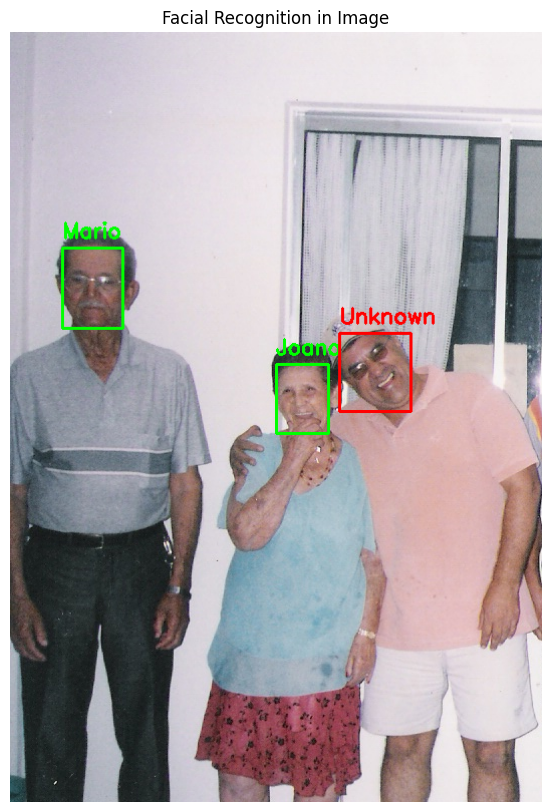

In [ ]:
base_path = '/content/drive/MyDrive/Facial_Recognition_Project/'
test_folder_path = os.path.join(base_path, 'test_files')

# Path to the test image
test_image_path = os.path.join(test_folder_path, 'test1.png')

# Execute photo recognition
recognize_faces_in_photo(test_image_path)

**Optional (if the test is on video): Function to recognize faces in a VIDEO FILE**

In [ ]:
"""
def recognize_faces_in_video(test_video_path, output_video_path=None):
    try:
        with open(os.path.join(models_path, 'svm_model.pkl'), 'rb') as f:
            svm_model = pickle.load(f)
        with open(os.path.join(models_path, 'label_encoder.pkl'), 'rb') as f:
            encoder = pickle.load(f)
    except FileNotFoundError:
        print("[ERROR] SVM or Encoder models not found. Make sure the training cells were executed successfully.")
        return

    detector = MTCNN()
    embedder = FaceNet()

    cap = cv2.VideoCapture(test_video_path)

    if not cap.isOpened():
        print(f"[ERROR] Could not open video file: {test_video_path}")
        return

    writer = None
    if output_video_path is not None:

        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
        print(f"[INFO] Saving output video to: {output_video_path}")


    print("[INFO] Starting video processing...")
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Convert from BGR to RGB for MTCNN/FaceNet
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect all faces in the frame
        results = detector.detect_faces(frame_rgb)

        # Iterate over each found face
        for resultado in results:
            x1, y1, width, height = resultado['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height

            # Crop the face, resize, and get the embedding
            face = frame_rgb[y1:y2, x1:x2]
            try:
                face_resized = cv2.resize(face, (160, 160))
                face_embedding = embedder.embeddings([face_resized])[0]
            except cv2.error:
                continue

            # Use the SVM to predict the identity
            embedding_for_prediction = np.expand_dims(face_embedding, axis=0)
            encoded_prediction = svm_model.predict(embedding_for_prediction)
            probabilities = svm_model.predict_proba(embedding_for_prediction)

            # Get the name and confidence
            prediction_index = encoded_prediction[0]
            confidence = probabilities[0][prediction_index] * 100
            person_name = encoder.inverse_transform(encoded_prediction)[0]

            # Define the confidence threshold
            confidence_threshold = 60.0

            if confidence > confidence_threshold:
                text = f"{person_name} ({confidence:.1f}%)"
                color = (0, 255, 0) # Green (in BGR)
            else:
                text = "Unknown"
                color = (0, 0, 255) # Red (in BGR)

            # Draw a rectangle and the text
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        if writer is not None:
            writer.write(frame)

        if frame_count % 100 == 0:
            print(f"  [INFO] Processing frame {frame_count} of {total_frames}...")

    cap.release()
    if writer is not None:
        writer.release()
    print("[INFO] Video processing complete!")
    """

**Executing video recognition**

In [ ]:
"""
base_path = '/content/drive/MyDrive/Facial_Recognition_Project/'
test_folder_path = os.path.join(base_path, 'test_files')
test_video_path = os.path.join(test_folder_path, 'test2.mp4')
output_video_path = os.path.join(test_folder_path, 'test_recognized.avi')
recognize_faces_in_video(test_video_path, output_video_path)
"""